In [ ]:
"""
Created on April 2024

Author: Fenia Psomouli
"""

In [5]:
#Import libraries
import os
import tempfile
import numpy as np
import rasterio
import pickle
import tensorflow as tf
from tensorflow import keras
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.gridspec import GridSpec
from matplotlib.colors import ListedColormap, BoundaryNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import colors
import matplotlib.colors as clr
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
from keras import layers
from keras import losses
from keras import models
from keras import metrics
from keras import optimizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

In [6]:
# Cloud authentication
from google.colab import auth
auth.authenticate_user()

In [ ]:
# Mount Google Drive to Google Colab
from google.colab import drive
if not os.path.exists('/content/drive'):
  drive.mount('/content/drive', force_remount=True)

In [ ]:
# Loading the list with the paths for the normalized data for both draining and refreezing lakes
draining_paths = np.load('/content/drive/MyDrive/Thesis/Data/file_pathsD64_normalized.npy', allow_pickle=True)
refreezing_paths = np.load('/content/drive/MyDrive/Thesis/Data/file_pathsR64_normalized.npy', allow_pickle=True)

# Combine draining and refreezing paths into one list, [:92] -> draining [92:] -> refreezing (93)
all_paths = np.concatenate((draining_paths, refreezing_paths)).tolist()

In [ ]:
# Folder and name of trained model
model_folder = '/content/drive/MyDrive/Results/Models'
model_name = 'test16'
# Specify model training parameters
BATCH_SIZE = 8
EPOCHS = 20
SIDE = 64
lr = 0.001

In [ ]:
# Load and use the data
def _parse_function(proto):
    feature_description = {
        'feature': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.string),
    }
    parsed_features = tf.io.parse_single_example(proto, feature_description)
    feature = tf.io.parse_tensor(parsed_features['feature'], out_type=tf.float32)
    label = tf.io.parse_tensor(parsed_features['label'], out_type=tf.int32)
    feature.set_shape([64, 64, 30])
    label.set_shape([64, 64])
    return feature, label


def load_dataset(tfrecord_file, batch_size):
    dataset = tf.data.TFRecordDataset(tfrecord_file)
    dataset = dataset.map(_parse_function)
    dataset = dataset.shuffle(1000).batch(batch_size) #.repeat()
    return dataset

In [ ]:
train_dataset = load_dataset('/content/drive/MyDrive/Results/Datasets_int/train.tfrecords', BATCH_SIZE)
validation_dataset = load_dataset('/content/drive/MyDrive/Results/Datasets_int/val.tfrecords', BATCH_SIZE)
test_dataset = load_dataset('/content/drive/MyDrive/Results/Datasets_int/test.tfrecords', BATCH_SIZE)
antarctica_dataset = load_dataset('/content/drive/MyDrive/Results/Datasets_int/test.tfrecords', BATCH_SIZE)

###U-net Model
Here we use a U-Net as implemented by de Roda Husman et al., (2024) in the paper titled "A high-resolution record of surface melt on Antarctic ice shelves using multi-source remote sensing data and deep learning"


###Designing the model

In [ ]:
class attention_unet():
  def __init__(self,img_rows=SIDE,img_cols=SIDE,learning_rate=lr):
    self.img_rows=img_rows
    self.img_cols=img_cols
    self.learning_rate = learning_rate #new
    self.img_shape=(self.img_rows,self.img_cols,30)
    self.df=32
    self.uf=32

  def build_unet(self):
    def conv2d(layer_input,filters,dropout_rate=0,bn=False):
      d=layers.Conv2D(filters,kernel_size=(3,3),strides=(1,1),padding='same')(layer_input)
      d=layers.Activation('relu')(d)
      d=layers.Conv2D(filters,kernel_size=(3,3),strides=(1,1),padding='same')(d)
      d=layers.Activation('relu')(d)

      if dropout_rate:
        d=layers.Dropout(dropout_rate)(d)

      return d

    def deconv2d(layer_input,filters,bn=False):
      u=layers.UpSampling2D((2,2))(layer_input)
      u=layers.Conv2D(filters,kernel_size=(3,3),strides=(1,1),padding='same')(u)
      u=layers.Activation('relu')(u)

      return u

    def attention_block(F_g,F_l,F_int,bn=False):
      g=layers.Conv2D(F_int,kernel_size=(1,1),strides=(1,1),padding='valid')(F_g)
      x=layers.Conv2D(F_int,kernel_size=(1,1),strides=(1,1),padding='valid')(F_l)
      psi=layers.Add()([g,x])
      psi=layers.Activation('relu')(psi)

      psi=layers.Conv2D(1,kernel_size=(1,1),strides=(1,1),padding='valid')(psi)
      psi=layers.Activation('sigmoid')(psi)

      return layers.Multiply()([F_l,psi])

    inputs=layers.Input(shape=self.img_shape)

    conv1=conv2d(inputs,self.df)
    pool1=layers.MaxPooling2D((2,2))(conv1)

    conv2=conv2d(pool1,self.df*2,bn=True)
    pool2=layers.MaxPooling2D((2,2))(conv2)

    conv3=conv2d(pool2,self.df*4,bn=True)
    pool3=layers.MaxPooling2D((2,2))(conv3)

    conv4=conv2d(pool3,self.df*8,dropout_rate=0.5,bn=True)
    pool4=layers.MaxPooling2D((2,2))(conv4)

    conv5=conv2d(pool4,self.df*16,dropout_rate=0.5,bn=True)

    up6=deconv2d(conv5,self.uf*8,bn=True)
    conv6=attention_block(up6,conv4,self.uf*8,bn=True)
    up6=layers.Concatenate()([up6,conv6])
    conv6=conv2d(up6,self.uf*8)

    up7=deconv2d(conv6,self.uf*4,bn=True)
    conv7=attention_block(up7,conv3,self.uf*4,bn=True)
    up7=layers.Concatenate()([up7,conv7])
    conv7=conv2d(up7,self.uf*4)

    up8=deconv2d(conv7,self.uf*2,bn=True)
    conv8=attention_block(up8,conv2,self.uf*2,bn=True)
    up8=layers.Concatenate()([up8,conv8])
    conv8=conv2d(up8,self.uf*2)

    up9=deconv2d(conv8,self.uf,bn=True)
    conv9=attention_block(up9,conv1,self.uf,bn=True)
    up9=layers.Concatenate()([up9,conv9])
    conv9=conv2d(up9,self.uf)

    outputs=layers.Conv2D(3,kernel_size=(1,1),strides=(1,1),activation='softmax')(conv9) #softmax

    model=models.Model(inputs=inputs,outputs=outputs)


    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics =[tf.keras.metrics.SparseCategoricalAccuracy(name ='accuracy')])

    return model

In [ ]:
m = attention_unet().build_unet()
m.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 30)]         0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 64, 64, 32)           8672      ['input_1[0][0]']             
                                                                                                  
 activation (Activation)     (None, 64, 64, 32)           0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 64, 64, 32)           9248      ['activation[0][0]']          
                                                                                              

###Training the model


In [ ]:
# Create list of callbacks for (1) learning rate scheduler, and (2) earlier stopping
early_stopping =  tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001, mode='min', verbose=1)
callbacks_list = [early_stopping, reduce_lr]

In [ ]:
# Fit model
history = m.fit(
     x=train_dataset,
     batch_size = BATCH_SIZE,
     epochs= EPOCHS,
     validation_data=validation_dataset,
     callbacks = callbacks_list)   #callbacks = callbacks_list, callbacks = [DetailedMetrics()]

Epoch 1/20
5/5 [==============================] - 43s 6s/step - loss: 0.9650 - accuracy: 0.6929 - val_loss: 0.8148 - val_accuracy: 0.7448 - lr: 0.0010
Epoch 2/20
5/5 [==============================] - 30s 5s/step - loss: 0.8053 - accuracy: 0.7357 - val_loss: 0.7680 - val_accuracy: 0.7448 - lr: 0.0010
Epoch 3/20
5/5 [==============================] - 26s 5s/step - loss: 0.7808 - accuracy: 0.7357 - val_loss: 0.7468 - val_accuracy: 0.7448 - lr: 0.0010
Epoch 4/20
5/5 [==============================] - 25s 5s/step - loss: 0.7479 - accuracy: 0.7357 - val_loss: 0.7144 - val_accuracy: 0.7448 - lr: 0.0010
Epoch 5/20
5/5 [==============================] - 27s 5s/step - loss: 0.7350 - accuracy: 0.7357 - val_loss: 0.8453 - val_accuracy: 0.7448 - lr: 0.0010
Epoch 6/20
5/5 [==============================] - 26s 5s/step - loss: 0.7482 - accuracy: 0.7357 - val_loss: 0.7041 - val_accuracy: 0.7448 - lr: 0.0010
Epoch 7/20
5/5 [==============================] - 25s 5s/step - loss: 0.6746 - accuracy: 0.735

In [ ]:
trained_model = model_folder + '/' + model_name

m.save(trained_model, save_format='tf')

In [ ]:
# Save model information to Google Drive
outputDir = '/content/drive/My Drive/Results/Models/test16/'

# Convert the history.history dict to a pandas DataFrame:
hist_df = pd.DataFrame(history.history)

# Save to csv:
hist_csv_file = outputDir + model_name + '.csv'
hist_df.to_csv(hist_csv_file)

###Prediction Step

In [8]:
# Load the trained model
trainedModel = tf.keras.models.load_model('/content/drive/MyDrive/Results/Models/test14')

In [9]:
# Greenland
batch_size = 8

# Load and use the testing data
def _parse_function(proto):
    feature_description = {
        'feature': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.string),
    }
    parsed_features = tf.io.parse_single_example(proto, feature_description)
    feature = tf.io.parse_tensor(parsed_features['feature'], out_type=tf.float32)
    label = tf.io.parse_tensor(parsed_features['label'],out_type=tf.int32)
    feature.set_shape([64, 64, 30])
    label.set_shape([64, 64])
    return feature, label

def load_dataset(tfrecord_file, batch_size):
    dataset = tf.data.TFRecordDataset(tfrecord_file)
    dataset = dataset.map(_parse_function)
    dataset = dataset.batch(batch_size)
    return dataset

changed_test_dataset = load_dataset('/content/drive/MyDrive/Results/Datasets_test_various/test_dataset_corrected_image_removed.tfrecords', batch_size)

1/1 [==============================] - 2s 2s/step
Draining
Image 1: Actual class = Draining, Predicted class = Draining
Label shape: (64, 64), Prediction shape: (64, 64)
Prediction matches label: True
Draining
Image 2: Actual class = Draining, Predicted class = Draining
Label shape: (64, 64), Prediction shape: (64, 64)
Prediction matches label: True
Draining
Image 3: Actual class = Draining, Predicted class = Draining
Label shape: (64, 64), Prediction shape: (64, 64)
Prediction matches label: True
Draining
Image 4: Actual class = Draining, Predicted class = Draining
Label shape: (64, 64), Prediction shape: (64, 64)
Prediction matches label: True
Draining
Image 5: Actual class = Draining, Predicted class = Draining
Label shape: (64, 64), Prediction shape: (64, 64)
Prediction matches label: True
Draining
Image 6: Actual class = Draining, Predicted class = Draining
Label shape: (64, 64), Prediction shape: (64, 64)
Prediction matches label: True
Draining
Image 7: Actual class = Draining, P

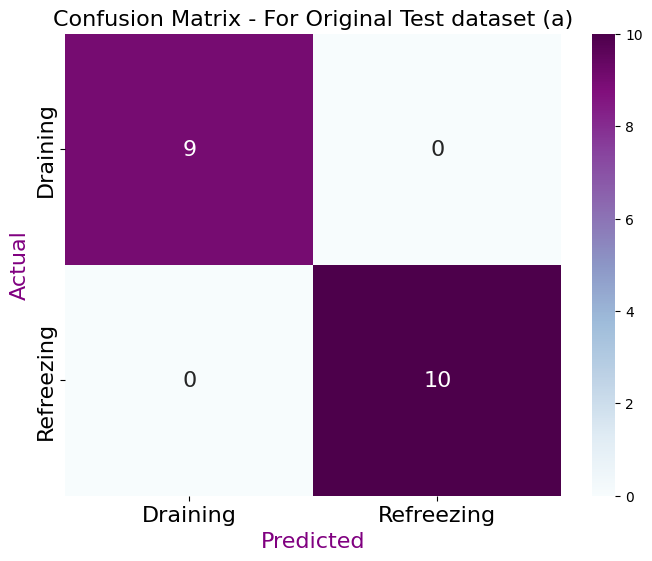

In [10]:
# Image-wise performance
def classify_image(image):
    """Classifies the image as draining, refreezing, or based on the majority class if both are present."""
    # Check if there are only 1s and not 2s present
    if np.any(image == 1) and not np.any(image == 2):
        return 'Draining'
    # Check if there are only 2s and not 1s present
    elif np.any(image == 2) and not np.any(image == 1):
        return 'Refreezing'
    # Check if both are present , if they are see which one is dominant
    elif np.any(image == 1) and np.any(image == 2):
        draining_count = np.sum(image == 1)
        refreezing_count = np.sum(image == 2)
        return 'Draining' if draining_count > refreezing_count else 'Refreezing'
    else:
        return 'invalid'
        print(draining_count, refreezing_count)

def evaluate_image_wise_metrics(changed_test_dataset, trainedModel):
    total_images = 0
    correct_images = 0
    true_positives = 0
    false_positives = 0
    false_negatives = 0
    true_negatives = 0

    all_labels = []
    all_predictions = []

    for features, labels in changed_test_dataset:
        prediction_probabilities = trainedModel.predict(features)
        predictions = np.argmax(prediction_probabilities, axis=-1)

        for i in range(features.shape[0]):
            label = labels[i].numpy()
            prediction = predictions[i]

            label_class = classify_image(label)
            print(label_class)
            prediction_class = classify_image(prediction)

            print(f"Image {i+1}: Actual class = {label_class}, Predicted class = {prediction_class}")
            print(f"Label shape: {label.shape}, Prediction shape: {prediction.shape}")
            print(f"Prediction matches label: {label_class == prediction_class}")
            all_labels.append(label_class)
            all_predictions.append(prediction_class)

            if label_class == 'Draining' and prediction_class == 'Draining':
                true_positives += 1
                correct_images += 1
            elif label_class == 'Draining' and prediction_class == 'Refreezing':
                false_positives += 1
            elif label_class == 'Refreezing' and prediction_class == 'Draining':
                false_negatives += 1
            elif label_class == 'Refreezing' and prediction_class == 'Refreezing':
                true_negatives += 1
                correct_images += 1

            total_images += 1

    accuracy = correct_images / total_images
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print(f"Image-wise Accuracy: {accuracy:.3f}")
    print(f"Image-wise Precision: {precision:.3f}")
    print(f"Image-wise Recall: {recall:.3f}")
    print(f"Image-wise F1 Score: {f1:.3f}")
    print(f"True Positives: {true_positives}, False Positives: {false_positives}, False Negatives: {false_negatives}, True Negatives: {true_negatives}")

    # Confusion matrix
    labels = ['Draining', 'Refreezing']
    cm = confusion_matrix(all_labels, all_predictions, labels=labels)
    print("Confusion Matrix:")
    print(cm)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='BuPu', xticklabels=labels, yticklabels=labels, annot_kws={"size": 16})
    plt.xlabel('Predicted', fontsize=16, color = 'purple')
    plt.ylabel('Actual', fontsize=16, color = 'purple')
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.title('Confusion Matrix - For Original Test dataset (a)', fontsize = 16)
    plt.show()

    return accuracy, precision, recall, f1, true_positives, false_positives, false_negatives, true_negatives


image_metrics = evaluate_image_wise_metrics(changed_test_dataset, trainedModel)

1/1 [==============================] - 0s 285ms/step
Confusion Matrix:
[[56581  1247   212]
 [ 1624  8760     0]
 [ 4197     0  5203]]
              precision    recall  f1-score   support

           0       0.91      0.97      0.94     58040
           1       0.88      0.84      0.86     10384
           2       0.96      0.55      0.70      9400

    accuracy                           0.91     77824
   macro avg       0.91      0.79      0.83     77824
weighted avg       0.91      0.91      0.90     77824

sklean acc:0.906
Pixel-wise Precision: 0.909
Pixel-wise Recall: 0.906
Pixel-wise F1 Score: 0.900
Actual Pixel counts: {0: 58040, 1: 10384, 2: 9400}
Predicted Pixel counts: {0: 62402, 1: 10007, 2: 5415}


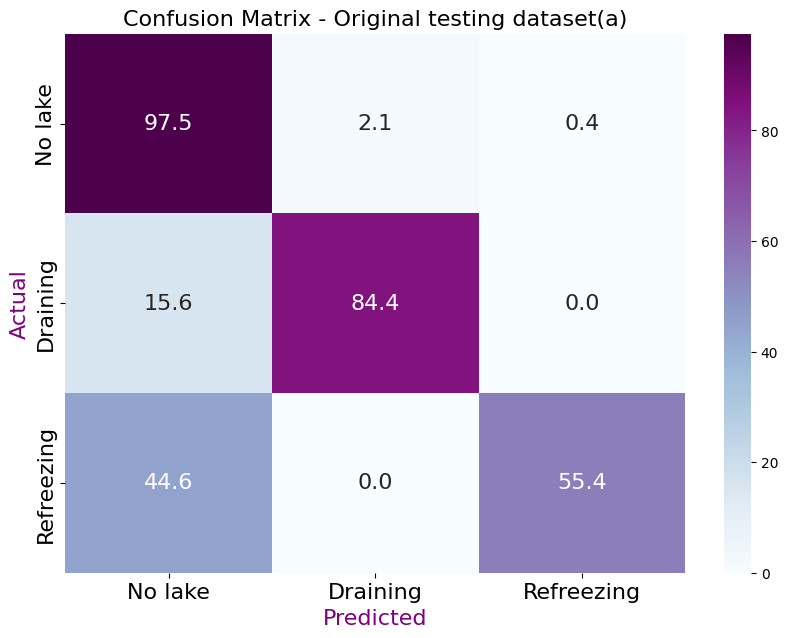

In [13]:
# Pixel wise performance
def evaluate_model_metrics(changed_test_dataset, trainedModel):
    all_labels = []
    all_predictions = []
    pixel_counts = {0: 0, 1: 0, 2: 0}  # Dictionary to store counts of pixels 0, 1, 2
    prediction_pixel_counts = {0: 0, 1: 0, 2: 0}


    # Process each batch in the test dataset
    for features, labels in changed_test_dataset:
        prediction_probabilities = trainedModel.predict(features)
        predictions = np.argmax(prediction_probabilities, axis=-1)

        for i in range(features.shape[0]):
            label = labels[i].numpy().flatten()
            prediction = predictions[i].flatten()

            all_labels.extend(label)
            all_predictions.extend(prediction)

        for value in pixel_counts:
            pixel_counts[value] += np.count_nonzero(labels == value)
            prediction_pixel_counts[value] += np.count_nonzero(predictions == value)


    sklearn_acc = accuracy_score(all_labels, all_predictions)
    report = classification_report(all_labels,all_predictions)

    precision_pixel = precision_score(all_labels, all_predictions, average='weighted', zero_division=0)
    recall_pixel = recall_score(all_labels, all_predictions, average='weighted', zero_division=0)
    f1_pixel = f1_score(all_labels, all_predictions, average='weighted', zero_division=0)
    cm = confusion_matrix(all_labels, all_predictions, labels=[0, 1, 2])
    print("Confusion Matrix:")
    print(cm)

    # Normalize confusion matrix by the number of samples in each true class
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    print(report)
    print(f'sklean acc:{sklearn_acc:.3f}')
    print(f"Pixel-wise Precision: {precision_pixel:.3f}")
    print(f"Pixel-wise Recall: {recall_pixel:.3f}")
    print(f"Pixel-wise F1 Score: {f1_pixel:.3f}")
    print(f"Actual Pixel counts:",pixel_counts)
    print(f"Predicted Pixel counts:",prediction_pixel_counts)

    # Plot confusion matrix
    labels = ['No lake', 'Draining', 'Refreezing']
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_normalized, annot=True, fmt='.1f', cmap='BuPu', xticklabels=labels, yticklabels=labels, annot_kws={"size": 16}) #BuPu , twilight
    plt.xlabel('Predicted', fontsize = 16, color = 'purple')
    plt.ylabel('Actual', fontsize = 16, color = 'purple')
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.title('Confusion Matrix - Original testing dataset(a)', fontsize = 16)
    plt.show()

    return sklearn_acc, report, precision_pixel, recall_pixel, f1_pixel, cm, pixel_counts,prediction_pixel_counts

metrics = evaluate_model_metrics(changed_test_dataset, trainedModel)

In [ ]:
# Antarctica
def _parse_function(proto):
    feature_description = {
        'feature': tf.io.FixedLenFeature([], tf.string),
        'lat': tf.io.FixedLenFeature([], tf.float32),
        'lon': tf.io.FixedLenFeature([], tf.float32)
    }
    parsed_features = tf.io.parse_single_example(proto, feature_description)
    feature = tf.io.parse_tensor(parsed_features['feature'], out_type=tf.float32)
    lat = parsed_features['lat']
    lon = parsed_features['lon']
    feature.set_shape([64, 64, 30])
    return feature, lat, lon

def load_dataset(tfrecord_file, batch_size):
    dataset = tf.data.TFRecordDataset(tfrecord_file)
    dataset = dataset.map(_parse_function)
    dataset = dataset.batch(batch_size) #Removed shuffle call
    return dataset

changed_test_dataset = load_dataset('/content/drive/MyDrive/Results/Dataset_Antarctica/antarctica_dataset_with_coords.tfrecords', batch_size)

In [ ]:
output_csv_path = '/content/drive/MyDrive/Results/ant_results_2.csv'

def classify_image(image):
    """Classifies the image as draining, refreezing, or based on the majority class if both are present."""
    # Check if there are only 1s and not 2s present
    if np.any(image == 1) and not np.any(image == 2):
        return 'Draining'
    # Check if there are only 2s and not 1s present
    elif np.any(image == 2) and not np.any(image == 1):
        return 'Refreezing'
    # Check if both are present, if they are see which one is dominant
    elif np.any(image == 1) and np.any(image == 2):
        draining_count = np.sum(image == 1)
        refreezing_count = np.sum(image == 2)
        return 'Draining' if draining_count > refreezing_count else 'Refreezing'
    else:
        return 'Invalid'

def make_predictions_and_save_results(changed_test_dataset, trainedModel, output_csv_path):
    results = []
    for features, lats, lons in changed_test_dataset:
        # Make prediction
        predictions = trainedModel.predict(features)

        for prediction, lat, lon in zip(predictions, lats.numpy(), lons.numpy()):
            # Determine the majority class in the prediction
            majority_class_label = classify_image(np.argmax(prediction, axis=-1))

            # Append result for the image
            results.append((lat, lon, majority_class_label))

    # Save results to CSV
    df = pd.DataFrame(results, columns=['latitude', 'longitude', 'label'])
    os.makedirs(os.path.dirname(output_csv_path), exist_ok=True)
    df.to_csv(output_csv_path, index=False)

make_predictions_and_save_results(changed_test_dataset, trainedModel, output_csv_path)

In [ ]:
def calculate_ssim(ground_truth, prediction):
    """Calculate the SSIM between the ground truth and the prediction."""
    ssim = tf.image.ssim(ground_truth, prediction, max_val=1.0)
    return ssim

def evaluate_ssim(changed_test_dataset, trainedModel):
    all_ssim_scores = []

    for features, labels in changed_test_dataset:
        prediction_probabilities = trainedModel.predict(features)
        predictions = np.argmax(prediction_probabilities, axis=-1)

        for i in range(features.shape[0]):
            ground_truth = labels[i]
            prediction = predictions[i]

            # Convert ground truth and prediction to tensors
            ground_truth_tensor = tf.convert_to_tensor(ground_truth, dtype=tf.int32)
            prediction_tensor = tf.convert_to_tensor(prediction, dtype=tf.int32)

            # Ensure the tensors have the same shape
            ground_truth_tensor = tf.expand_dims(ground_truth_tensor, axis=-1)
            prediction_tensor = tf.expand_dims(prediction_tensor, axis=-1)

            # Calculate SSIM
            ssim_score = calculate_ssim(ground_truth_tensor, prediction_tensor)
            all_ssim_scores.append(ssim_score.numpy())

    average_ssim = np.mean(all_ssim_scores)
    print(f"Average SSIM: {average_ssim:.4f}")
    return average_ssim

average_ssim = evaluate_ssim(changed_test_dataset, trainedModel)
print("Calculated Average SSIM:", average_ssim)